In [1]:
import os
import xarray as xa
import numpy as np
import dask.dataframe as dd

from hackathon_utils import *
from IPython.display import Image


In [2]:
# Connection strings has to be set as environmental variables if run outside the Ocean Data Connector
#os.environ['HACKATHON_DB_CONNECTION'] = ''
#os.environ['HACKATHON_CONNECTION_STR']= ''

In [ ]:
from dask.distributed import Client
client=Client(n_workers=4)

In [4]:
store_list=get_zarr_from_blob('zarr/vessel_emissions_and_traffic')
ds = xa.open_mfdataset(store_list, parallel=True, engine="zarr")
ds

,Array,Chunk
Bytes,6.79 GiB,7.63 MiB
Shape,"(28, 3972, 8194)","(1, 1000, 1000)"
Count,1009 Tasks,1008 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,6.79 GiB,7.63 MiB
Shape,"(28, 3972, 8194)","(1, 1000, 1000)"
Count,1009 Tasks,1008 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


# Emissions in the Australia - Japan iron ore green corridor


Every year million tonnes of iron ore is shipped form the Pilbara region in Australia to Japan. Emissions could potentially be massively redised by changing the fuel to green ammonium, which would make this a green corridor. Looking at the situation in his potential green corridor today will help get some insight.

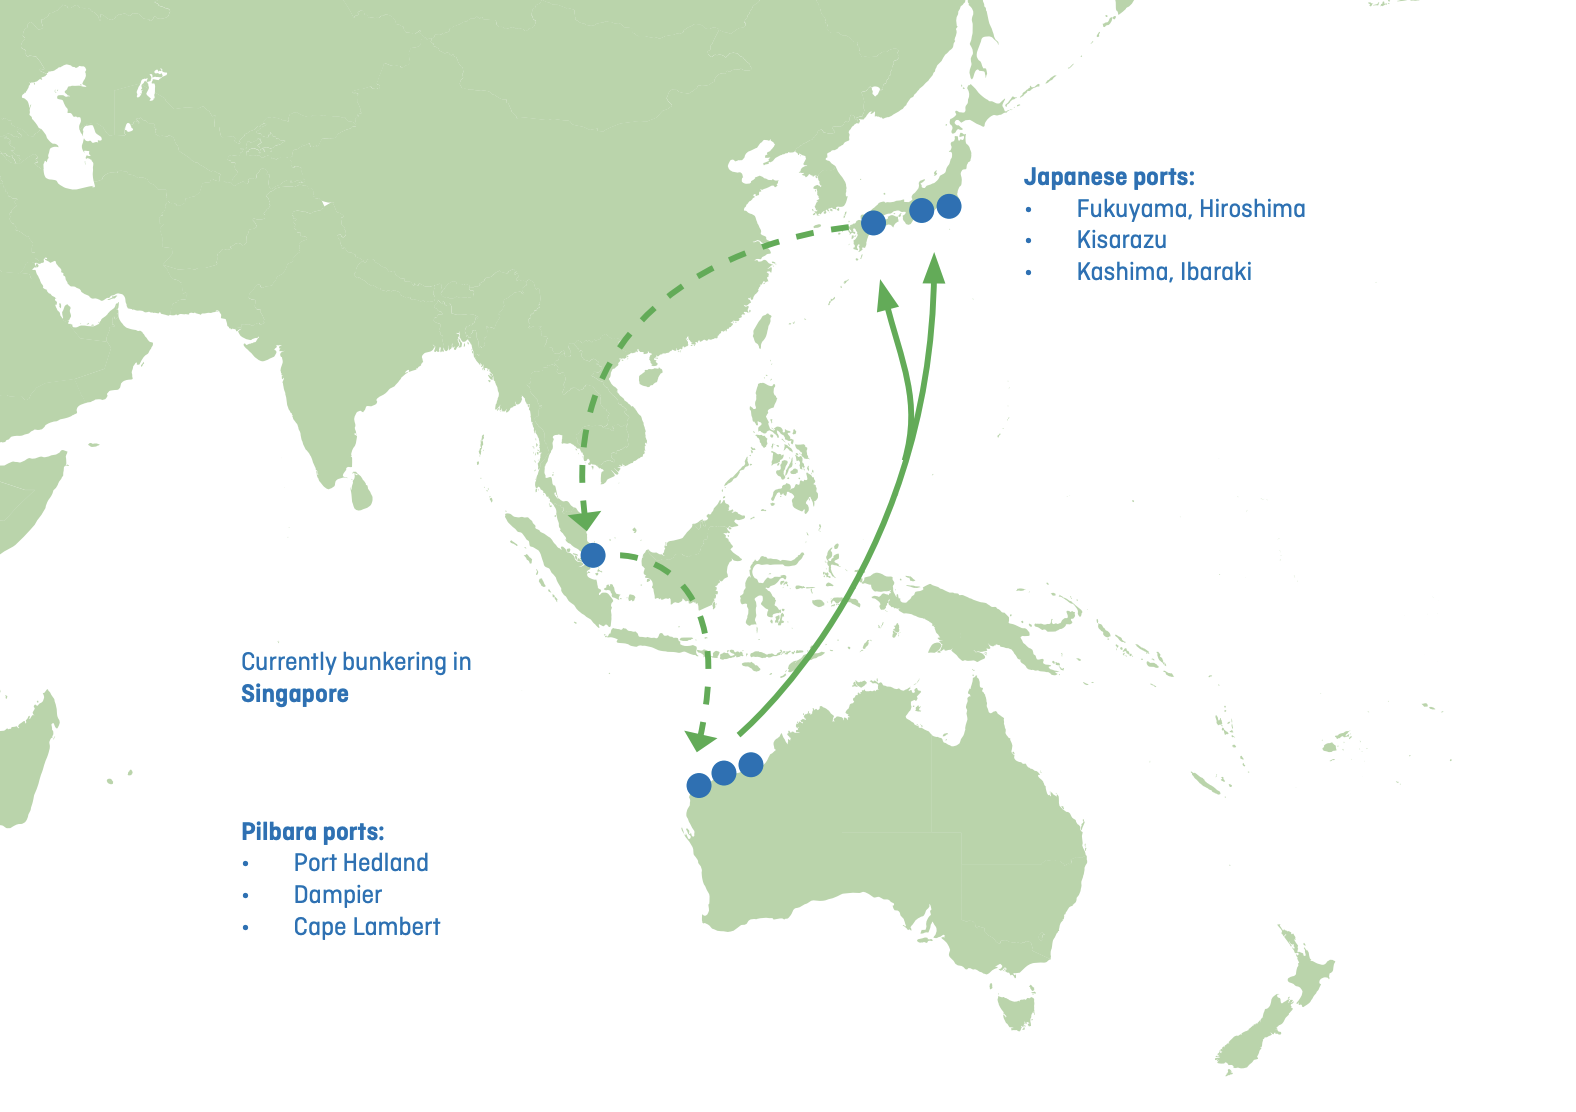

In [5]:
image = Image('figs/iron_ore_green_corridor.png') 
display(image)

## Finding the coordinates of the ports

In [6]:
df_ports, coords = get_lon_lat_ports(['KASHIMA','FUKUYAMA','KISARAZU','SINGAPORE','PORT HEDLAND','DAMPIER','PORT WALCOTT'])
#Lambert = PORT WALCOTT


Could not find Kashima, trying a broader search
Found the ports ['Kashima Ko']


Is one of these the right port? Type in the index of the right port, that is a number between 1 and 1. Press N if all are wrong. 1


Could not find Kisarazu, trying a broader search
Found the ports ['Kisarazu Ko']


Is one of these the right port? Type in the index of the right port, that is a number between 1 and 1. Press N if all are wrong. 1


Could not find Singapore, trying a broader search
Found the ports ['Keppel - (East Singapore)']


Is one of these the right port? Type in the index of the right port, that is a number between 1 and 1. Press N if all are wrong. 1


In [7]:
df_ports

,Main Port Name,Country Code,Latitude,Longitude
0,Kashima Ko,Japan,35.933333,140.700000
1,Fukuyama,Japan,34.433333,133.433333
2,Kisarazu Ko,Japan,35.366667,139.883333
3,Keppel - (East Singapore),Singapore,1.283333,103.850000
4,Port Hedland,Australia,-20.316667,118.583333
5,Dampier,Australia,-20.633333,116.716667
6,Port Walcott,Australia,-20.650000,117.183333


In [8]:
coords

[[140.7, 35.933333],
 [133.433333, 34.433333],
 [139.883333, 35.366667],
 [103.85, 1.283333],
 [118.583333, -20.316667],
 [116.716667, -20.633333],
 [117.183333, -20.65]]

### CO2 emissions in 2021 for the Japan-Australia iron ore green corridor

In [9]:
ds_total_co2 = ds.sel(lon=slice(100,143),
                lat=slice(-25,38),
                time=slice('2021-01-01','2022-01-01')).co2_total.compute()

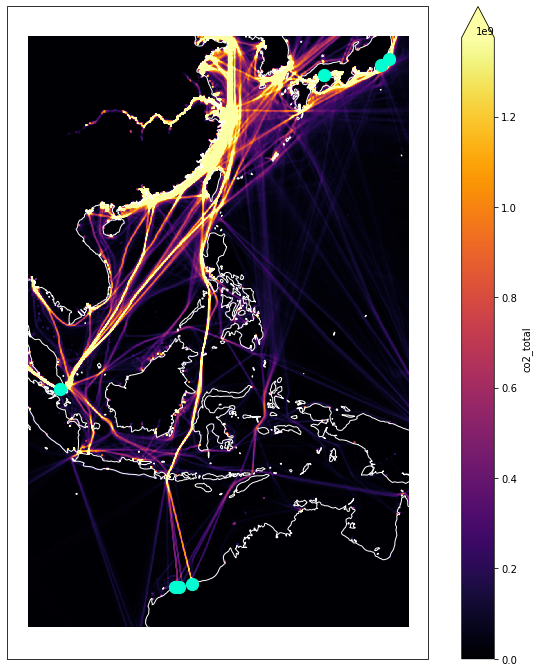

In [10]:
plot_emissions_density_ports(ds_total_co2.sum('time').rolling(lat=5,lon=5).mean(),df_ports)


In [11]:
print(f"Total CO2 emissions in selected area and time period estimated to {(ds_total_co2.sum(['lon','lat','time']).data/1e6):.1f} mT")



Total CO2 emissions in selected area and time period estimated to 313132239.4 mT


### Density in 2021 for the Japan-Australia iron ore green corridor

In [12]:
ds_hours_total = ds.sel(lon=slice(100,143),
                lat=slice(-25,38),
                time=slice('2021-01-01','2022-01-01')).hours_total.compute()


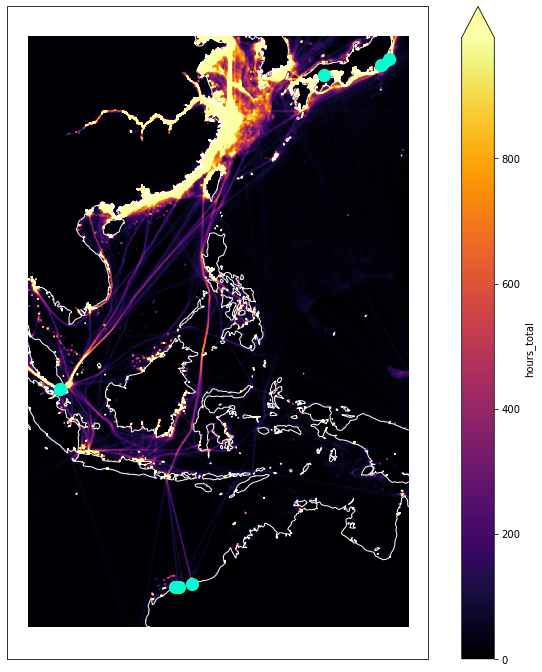

In [13]:
plot_emissions_density_ports(ds_hours_total.sum('time').rolling(lat=5,lon=5).mean(),df_ports)

In [14]:
print(f"Total hours spent in selected area and time period estimated to {(ds_hours_total.sum(['lon','lat','time']).data/1e6):.1f} million hours")


Total hours spent in selected area and time period estimated to 410.5 million hours


## Voyages in the green corridor

Below are the folders for each vessel cathegory

In [15]:
# Available folders divided into vessel categories
folders=['parquet/voyage_tables/Bulk carrier/',
 'parquet/voyage_tables/Chemical tanker/',
 'parquet/voyage_tables/Container/',
 'parquet/voyage_tables/Cruise/',
 'parquet/voyage_tables/Ferry-pax only/',
 'parquet/voyage_tables/Ferry-ro-pax/',
 'parquet/voyage_tables/General cargo/',
 'parquet/voyage_tables/Liquefied gas tanker/',
 'parquet/voyage_tables/Offshore/',
 'parquet/voyage_tables/Oil tanker/',
 'parquet/voyage_tables/Other liquid tankers/',
 'parquet/voyage_tables/Refrigerated bulk/',
 'parquet/voyage_tables/Ro-ro/',
 'parquet/voyage_tables/Vehicle/']

Choose the index of the vessel cathegory in interest. Here, bulk carriers with the index 0 is chosen as these are teh most relevant in the iron ore route.

In [16]:
file_list=get_files_from_blob(folders[0])
print(f'Total number of voyage files : {len(file_list)}')

Total number of voyage files : 11724


Find all voyages for the selected vessel cathegory

In [17]:
df_all_voy=dd.read_parquet(file_list, storage_options={"connection_string": os.environ['HACKATHON_CONNECTION_STR']})


Finding voyages in the iron ore green corridor for bulk carriers.

In [18]:
%%time
df_singapore_australia=df_all_voy[((df_all_voy.from_port=='KEPPEL - (EAST SINGAPORE)')&((df_all_voy.to_port=='PORT HEDLAND')|(df_all_voy.to_port=='DAMPIER')|(df_all_voy.to_port=='PORT WALCOTT')))|((df_all_voy.to_port=='KEPPEL - (EAST SINGAPORE)')&((df_all_voy.from_port=='PORT HEDLAND')|(df_all_voy.from_port=='DAMPIER')|(df_all_voy.from_port=='PORT WALCOTT')))].compute().sort_values(by='distance_nm',ascending=True).reset_index(drop=True)


CPU times: user 54.6 s, sys: 4.93 s, total: 59.5 s
Wall time: 2min 11s


In [19]:
%%time
df_japan_singapore=df_all_voy[((df_all_voy.to_port=='KEPPEL - (EAST SINGAPORE)')&((df_all_voy.from_port=='FUKUYAMA')|(df_all_voy.from_port=='KISARAZU KO')|(df_all_voy.from_port=='KASHIMA KO')))|((df_all_voy.from_port=='KEPPEL - (EAST SINGAPORE)')&((df_all_voy.to_port=='FUKUYAMA')|(df_all_voy.to_port=='KISARAZU KO')|(df_all_voy.to_port=='KASHIMA KO')))].compute().sort_values(by='distance_nm',ascending=True).reset_index(drop=True)



CPU times: user 44.2 s, sys: 4.15 s, total: 48.3 s
Wall time: 1min 55s


In [20]:
%%time
df_australia_japan=df_all_voy[(((df_all_voy.from_port=='PORT HEDLAND')|(df_all_voy.from_port=='DAMPIER')|(df_all_voy.from_port=='PORT WALCOTT'))&((df_all_voy.to_port=='FUKUYAMA')|(df_all_voy.to_port=='KISARAZU KO')|(df_all_voy.to_port=='KASHIMA KO')))|(((df_all_voy.to_port=='PORT HEDLAND')|(df_all_voy.to_port=='DAMPIER')|(df_all_voy.to_port=='PORT WALCOTT'))&((df_all_voy.from_port=='FUKUYAMA')|(df_all_voy.from_port=='KISARAZU KO')|(df_all_voy.from_port=='KASHIMA KO')))].compute().sort_values(by='distance_nm',ascending=True).reset_index(drop=True)


CPU times: user 44.9 s, sys: 4.15 s, total: 49.1 s
Wall time: 1min 54s


Take a look at the data for voyages between Australia and Japan

In [21]:
df_australia_japan.head()

,Unnamed: 0,voyage_departure,voyage_arrival,from_port,to_port,co2_kg,duration_hours,distance_nm,interpolated_ratio,avg_speed_knts,mmsi,vessel_type
0,14,2020-11-07 21:00:00+00:00,2020-11-30 07:00:00+00:00,FUKUYAMA,PORT HEDLAND,2.618053e+06,538,3454.463803,0.098696,6.494507,373657000,Bulk carrier
1,2,2020-02-18 17:00:00+00:00,2020-03-08 16:00:00+00:00,FUKUYAMA,PORT HEDLAND,2.458627e+06,455,3492.733835,0.149780,7.699559,354680000,Bulk carrier
2,16,2020-12-04 00:00:00+00:00,2020-12-19 01:00:00+00:00,FUKUYAMA,PORT HEDLAND,1.727153e+06,361,3502.617728,0.136111,9.730694,370956000,Bulk carrier
3,16,2020-12-13 21:00:00+00:00,2020-12-30 09:00:00+00:00,FUKUYAMA,PORT HEDLAND,2.616971e+06,396,3506.127172,0.192405,8.908608,351833000,Bulk carrier
4,15,2020-11-09 18:00:00+00:00,2020-11-27 00:00:00+00:00,FUKUYAMA,PORT HEDLAND,2.433974e+06,414,3523.765274,0.147700,8.591041,432752000,Bulk carrier


#### Visualising voyages between Astralia, Japan and Singapore

In [22]:
index=6
df_emissions1=load_data(df_australia_japan['mmsi'].iloc[index])
df_voyage1=df_emissions1[df_australia_japan['voyage_departure'].iloc[index]:df_australia_japan['voyage_arrival'].iloc[index]]


In [23]:
df_row = df_japan_singapore[df_japan_singapore['from_port']=='FUKUYAMA'].iloc[0]
df_emissions2 = load_data(df_row['mmsi'])
df_voyage2 = df_emissions2[df_row['voyage_departure']:df_row['voyage_arrival']]


In [24]:
df_row = df_singapore_australia[df_singapore_australia['to_port']=='PORT HEDLAND'].iloc[0]
df_emissions3 = load_data(df_row['mmsi'])
df_voyage3 = df_emissions3[df_row['voyage_departure']:df_row['voyage_arrival']]

In [25]:
plot_df(pd.concat([df_voyage1,df_voyage2,df_voyage3]))

{"initialViewState": {"latitude": 6.145354279127369, "longitude": 120.64286872750496, "zoom": 2}, "layers": [{"@@type": "PathLayer", "data": [{"path": [[118.58411, -20.3244], [118.5860016667, -20.293755], [118.51271, -20.178405], [118.4299183333, -20.0103833333], [118.53488, -19.7978933333], [118.6408533333, -19.5831733333], [118.75288, -19.35952], [118.87144, -19.1223466667], [118.9674666667, -18.9293066667], [119.0775733333, -18.70552], [119.1763733333, -18.5108266667], [119.32256, -18.2105066667], [119.3824533333, -18.0917333333], [119.4783466667, -17.89944], [119.5827466667, -17.68968], [119.6981333333, -17.45224], [119.8325866667, -17.19848], [119.8950133333, -17.0589066667], [119.97928, -16.8307733333], [120.06432, -16.6210666667], [120.207575, -16.270405], [120.2373066667, -16.1949066667], [120.3536533333, -15.9062666667], [120.4290133333, -15.7217066667], [120.5043733333, -15.5371466667], [120.6057333333, -15.2870133333], [120.6802666667, -15.10392], [120.8110933333, -14.81424], [120.86992, -14.6401333333], [120.9463733333, -14.4490133333], [121.0569066667, -14.17096], [121.1266133333, -13.9950933333], [121.2173866667, -13.77472], [121.3096533333, -13.54352], [121.4071466667, -13.2979733333], [121.5251733333, -13.0068266667], [121.58297, -12.8615016667], [121.6637866667, -12.6578933333], [121.7488266667, -12.4480533333], [121.8388533333, -12.22392], [121.93072, -11.99408], [122.0418933333, -11.71536], [122.1036266667, -11.5586133333], [122.2061866667, -11.3022933333], [122.32192, -11.0145866667], [122.42161333335, -10.8101066667], [122.5213066667, -10.6056266667], [122.6817066667, -10.3190933333], [122.7288266667, -10.23584], [122.83448, -10.0508], [122.9558133333, -9.83616], [123.1226666667, -9.5416], [123.2666666667, -9.285], [123.3072533333, -9.21696], [123.43424, -8.9898666667], [123.5506666667, -8.7845333333], [123.6946133333, -8.5284533333], [123.80568, -8.3334933333], [123.95252, -8.10634666665], [124.09936, -7.8792], [124.1364, -7.7965333333], [124.224, -7.5818133333], [124.3303466667, -7.3676], [124.4102666667, -7.1203733333], [124.49744, -6.9073066667], [124.6017066667, -6.6477333333], [124.6835733333, -6.4472533333], [124.7746933333, -6.2221866667], [124.865546666633, -5.9525866667], [124.956399999967, -5.6829866667], [125.0472533333, -5.4133866667], [125.087585, -5.2799933333], [125.16336, -5.0541866667], [125.2413333333, -4.81512], [125.3140533333, -4.5905066667], [125.4328533333, -4.22496], [125.46408, -4.1292266667], [125.5389333333, -3.90312], [125.609265, -3.6843816667], [125.7297983333, -3.3129183333], [125.8291208333, -3.13458666665], [125.9284433333, -2.956255], [126.0911466667, -2.7145866667], [126.177215, -2.5853616667], [126.304, -2.39392], [126.4397866667, -2.2158666667], [126.5742133333, -2.0105066667], [126.6249066667, -1.7102133333], [126.6415733333, -1.56752], [126.6468266667, -1.32192], [126.6474133333, -1.1181333333], [126.6488133333, -0.86488666665], [126.6502133333, -0.61164], [126.6516133333, -0.35839333335], [126.6530133333, -0.1051466667], [126.698325, 0.07813], [126.7232, 0.2098666667], [126.7667333333, 0.4227833333], [126.7955466667, 0.59816], [126.8352266667, 0.8121333333], [126.88512, 1.0316], [126.9342933333, 1.22696], [127.0096883333, 1.5078583333], [127.076099999967, 1.7589561111], [127.142511666633, 2.0100538889], [127.2089233333, 2.2611516667], [127.25304, 2.4339733333], [127.3149066667, 2.65192], [127.3518666667, 2.8069066667], [127.4266133333, 3.0476266667], [127.4654933333, 3.2207466667], [127.52539, 3.4358566667], [127.6357233333, 3.866485], [127.6476533333, 3.9133066667], [127.7325066667, 4.2346816667], [127.7821791667, 4.42397333335], [127.8318516667, 4.613265], [127.88696333335, 4.81818083335], [127.942075, 5.0230966667], [128.02464, 5.3364], [128.0612266667, 5.4698666667], [128.1345866667, 5.74656], [128.18096, 5.92288], [128.23984, 6.1442933333], [128.34, 6.5216666667], [128.3585066667, 6.58952], [128.4297688889, 6.85582222223333], [128.5010311111, 7.12212444446667],

#### Missing ports

We have about 3700 ports in the database which means that not all ports exist. This results in some voyages appearing longer than they are as the stop in some ports are not registered as stops. A voyage could look like this

In [26]:
index=-2
df_emissions1=load_data(df_australia_japan['mmsi'].iloc[index])
df_voyage1=df_emissions1[df_australia_japan['voyage_departure'].iloc[index]:df_australia_japan['voyage_arrival'].iloc[index]]
plot_df(df_voyage1)


/Users/kristianauthen/Documents/GitHub/OceanDataConnector/data/VesselEmissions/hackathon_utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point['difference'] = (point.lon - point.lon.shift()).abs()
/Users/kristianauthen/Documents/GitHub/OceanDataConnector/data/VesselEmissions/hackathon_utils.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point.drop('difference', axis=1, inplace=True)


{"initialViewState": {"latitude": 10.555095814080564, "longitude": 136.64086860862952, "zoom": 2}, "layers": [{"@@type": "PathLayer", "data": [{"path": [[118.56916, -20.3159433333], [118.5871166667, -20.2839216667], [118.4999316667, -20.157095], [118.4251866667, -20.02052], [118.4305, -19.8329433333], [118.3818983333, -19.6361766667], [118.338785, -19.483725], [118.2865216667, -19.2940416667], [118.221515, -19.0578066667], [118.175995, -18.842125], [118.1332316667, -18.6796966667], [118.0755916667, -18.4466366667], [118.0432, -18.3174283333], [118.0000983333, -18.1361666667], [117.944255, -17.9432166667], [117.8950666667, -17.726155], [117.8390716667, -17.5022466667], [117.8015716667, -17.3564783333], [117.7554566667, -17.1755466667], [117.70538, -16.9874833333], [117.6535483333, -16.7965866667], [117.569265, -16.4427766667], [117.533600555567, -16.3036938889], [117.497936111133, -16.1646111111], [117.4622716667, -16.0255283333], [117.4221116667, -15.8746316667], [117.3836183333, -15.69724], [117.3350266667, -15.520505], [117.2876183333, -15.3295183333], [117.2241933333, -15.0803116667], [117.1958433333, -14.9719766667], [117.1460516667, -14.7897933333], [117.1076666667, -14.6355583333], [117.0651283333, -14.450685], [117.02139, -14.2594783333], [116.9389383333, -13.951775], [116.9303, -13.9135916667], [116.87019, -13.6610983333], [116.8372916667, -13.5316233333], [116.7870716667, -13.3308633333], [116.69503, -13.000815], [116.6910666667, -12.9846783333], [116.646845, -12.7941166667], [116.6039833333, -12.6030333333], [116.53942, -12.3452633333], [116.490577916675, -12.14998666665], [116.44173583335, -11.95471], [116.392893750025, -11.75943333335], [116.3440516667, -11.5641566667], [116.31178, -11.4316233333], [116.28081, -11.295845], [116.2329916667, -11.0955366667], [116.1505116667, -10.75649], [116.1033716667, -10.5947566667], [116.06471, -10.4238316667], [116.0194933333, -10.231835], [115.9520766667, -9.9780283333], [115.9138916667, -9.8359233333], [115.8702533333, -9.6515316667], [115.7954233333, -9.3334933333], [115.78374, -9.2856783333], [115.72923, -9.0760316667], [115.7283566667, -8.82387], [115.7291783333, -8.82245], [115.75641, -8.7391966667], [115.8060216667, -8.59792], [115.8549716667, -8.4520733333], [115.9251016667, -8.2599166667], [116.0164016667, -8.0435683333], [116.1277383333, -7.7893266667], [116.1875570833, -7.6580616667], [116.2473758333, -7.5267966667], [116.3071945833, -7.3955316667], [116.3670133333, -7.2642666667], [116.468045, -7.0356733333], [116.5481075, -6.85277416665], [116.62817, -6.669875], [116.690245, -6.533395], [116.771793333333, -6.34407055556667], [116.853341666667, -6.15474611113333], [116.93489, -5.9654216667], [116.9835575, -5.8492866667], [117.032225, -5.7331516667], [117.18837, -5.465095], [117.2465083333, -5.3673033333], [117.2917066667, -5.2857333333], [117.379455, -5.1229783333], [117.4977325, -4.9096183333], [117.61601, -4.6962583333], [117.6618316667, -4.61387], [117.8097833333, -4.3636966667], [117.850475, -4.2881083333], [117.9459783333, -4.1001783333], [118.078565, -3.8647783333], [118.18575333335, -3.6693125], [118.2929416667, -3.4738466667], [118.3729833333, -3.32167], [118.43037, -3.2259016667], [118.4620416667, -3.1019666667], [118.4873666667, -2.9513116667], [118.5202366667, -2.7666216667], [118.5531066667, -2.5819316667], [118.5859766667, -2.3972416667], [118.61558, -2.2088216667], [118.652209375, -1.9915677083625], [118.68883875, -1.774313750025], [118.725468125, -1.5570597916875], [118.7620975, -1.33980583335], [118.798726875, -1.1225518750125], [118.83535625, -0.905297916675], [118.871985625, -0.6880439583375], [118.908615, -0.47079], [118.938983333333, -0.288901666666667], [118.969351666667, -0.107013333333333], [118.99972, 0.074875], [119.026093888892, 0.260788333333333], [119.052467777783, 0.446701666666667], [119.078841666675, 0.632615], [119.105215555567, 0.818528333333333], [119.131589444458, 1.00444166666667], [119.15796333335, 1.190355], [119.184337222242, 1.

Therefore we need to filter out the voyages that are longer than expected. 

In [27]:
df_singapore_australia = df_singapore_australia[df_singapore_australia['distance_nm']<5700]
df_japan_singapore = df_japan_singapore[df_japan_singapore['distance_nm']<11000]
df_australia_japan = df_australia_japan[df_australia_japan['distance_nm']<15300]

### Total amount of CO2 emissions between Australia and Japan in 2020 and 2021 from bulk carriers

In [28]:
co2_australia_japan = np.nansum(df_australia_japan['co2_kg'])
print(f'{(co2_australia_japan):.1f} tonnes of CO2 between Australia and Japan in 2020 and 2021.')

648613719.5 tonnes of CO2 between Australia and Japan in 2020 and 2021.


### Total amount of CO2 emissions between Japan and Singapore in 2020 and 2021 from bulk carriers

In [29]:
co2_japan_singapore = np.nansum(df_japan_singapore['co2_kg'])
print(f'{(co2_japan_singapore):.1f} tonnes of CO2 between Japan and Singapore in 2020 and 2021.')


101359993.5 tonnes of CO2 between Japan and Singapore in 2020 and 2021.


### Total amount of CO2 emissions between Singapore and Australia in 2020 and 2021 from bulk carriers

In [30]:
co2_singapore_australia = np.nansum(df_singapore_australia['co2_kg'])
print(f'{(co2_singapore_australia):.1f} tonnes of CO2 between Singapore and Australia in 2020 and 2021.')


130217191.0 tonnes of CO2 between Singapore and Australia in 2020 and 2021.


### Total amount of CO2 emissions between Australia - Japan - Singapore in 2020 and 2021 from bulk carriers

In [31]:
total_co2 = co2_australia_japan + co2_japan_singapore + co2_singapore_australia

In [32]:
print(f'{total_co2:.1f} tonnes of CO2 in the Australia Japan iron ore green corridor in 2020 and 2021')

880190904.0 tonnes of CO2 in the Australia Japan iron ore green corridor in 2020 and 2021
